In [ ]:
%run ../modules/QPCA

In [2]:
from qiskit import(
  QuantumCircuit,
  execute,
  BasicAer,
  QuantumRegister,
  ClassicalRegister)
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.states import DensityMatrix, Statevector
import math
import scipy
import numpy as np
from scipy.stats import ortho_group

In [3]:
def mixed_state_purification(states, weights):
    I = np.identity(len(states))
    psi_i = []
    for i, state in enumerate(states):
        psi_i.append(np.sqrt(weights[i]) * np.kron(state, I[i]))
    psi = np.add.reduce(psi_i)
    return psi

def select_eigenvalues(eigenvalues_occurrences, bits, n):
    max_val = 1
    relevant_eigvals = []

    for i in range(n):
        eigenvalues_occurrences = [j for j in eigenvalues_occurrences if j[0] <= max_val]
        if len(eigenvalues_occurrences)<=0:
            break
        most_relevant = eigenvalues_occurrences.pop(-1)[0]
        max_val -= most_relevant - (0.5**(bits+1))
        relevant_eigvals.append(most_relevant)
    return relevant_eigvals

In [4]:
N = 4
n = int(math.ceil(math.log2(N)))

D = scipy.random.rand(10,N)*20
means = np.mean(D,axis=0)
u=np.ones(len(D))[None] 
u=u.reshape((len(D),1)) 
means=means.reshape((len(D[0]),1))
centered = D-np.dot(u,means.T)

#Compute the covariance matrix
covariance_matrix=(1/(len(D)-1)) * np.dot(np.transpose(np.conj(centered)), centered)
covariance_matrix = covariance_matrix/np.trace(covariance_matrix)

In [5]:
eigval, eigvec = np.linalg.eig(covariance_matrix)
idx = np.argsort(eigval)
eigval = eigval[idx]
eigvec = eigvec[:,idx]

print(eigval)
print(eigvec)

[0.03992755 0.11195527 0.29906101 0.54905617]
[[ 0.5937224   0.73626048 -0.15326301 -0.28622487]
 [ 0.32591447 -0.0306142   0.940232    0.09384198]
 [-0.40703375  0.60964411  0.09370048  0.67370454]
 [-0.61285969  0.29209132  0.28929995 -0.6748268 ]]


In [6]:
random_pure_states = ortho_group.rvs(dim=N)
initial_weights = [1/N] * N

psi = mixed_state_purification(random_pure_states, initial_weights)
psi = np.concatenate((psi, [0] * (2**math.ceil(math.log2(len(psi))) - len(psi))))

In [7]:
# INITIALIZE CIRCUIT WITH MIXED STATE, USING ANCILLA QUBITS
q = QuantumRegister(n)
q_ancilla = QuantumRegister(n)
circuit = QuantumCircuit(q_ancilla, q)
circuit.initialize(psi, range(2*n))

In [8]:
nbits = 8

qpca = QPCA(covariance_matrix, nbits)
qpca.from_initial_circuit(circuit, q)

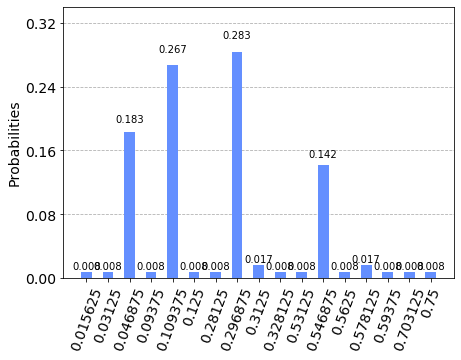

In [10]:
roundoff = 2

qpca_result = qpca.execute(roundoff, req_shots=(10*N))
plot_histogram(qpca_result.get_eigvals(False))

In [11]:
eigenvalues_est = np.array(select_eigenvalues(qpca_result.get_eigvals(), roundoff, N))
eigenvalues_est = [x for x in  eigenvalues_est if len(qpca_result.eigvec_from_eigval(x)) > 0]
eigenvectors_est = [qpca_result.eigvec_from_eigval(x) for x in eigenvalues_est]

print(eigenvalues_est)

# normalize in case it is needed
eigenvalues_est = eigenvalues_est / sum(eigenvalues_est) 

psi = mixed_state_purification(eigenvectors_est, eigenvalues_est)
psi = np.concatenate((psi, [0] * (2**math.ceil(math.log2(len(psi))) - len(psi))))

[0.296875, 0.109375, 0.046875, 0.546875]


In [15]:
q = QuantumRegister(n)
q_ancilla = QuantumRegister(n)
circuit = QuantumCircuit(q_ancilla, q)
circuit.initialize(psi, range(2*n))

qpca = QPCA(covariance_matrix, nbits)
qpca.from_initial_circuit(circuit, q)

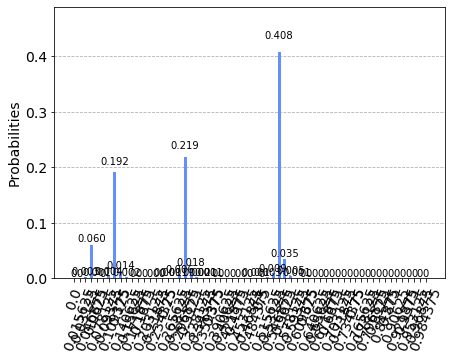

In [16]:
qpca_result.merge(qpca.execute(roundoff, req_shots=(1000 * N)))
plot_histogram(qpca_result.get_eigvals(False))

In [17]:
K = 2

#RETRIEVE EIGVECTORS ESTIMATES
eigenvalues_est = sorted(select_eigenvalues(qpca_result.get_eigvals(), roundoff, N))
eigenvalues_est = [i for i in eigenvalues_est[-K:]]
print("eigenvalues considered ", eigenvalues_est)
eigenvectors_est = [qpca_result.eigvec_from_eigval(x) for x in eigenvalues_est]

eigval_diag = np.diag(eigenvalues_est)
eigenvectors_est = np.array(eigenvectors_est).T

lowrank_covmat_est = np.matmul(np.matmul(eigenvectors_est,eigval_diag),eigenvectors_est.T)
lowrank_covmat = np.matmul(np.matmul(eigvec[:,-K:],np.diag(eigval[-K:])),eigvec[:,-K:].T)
diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

eigenvalues considered  [0.296875, 0.546875]
reconstruction error l2 norm  0.02517648076230683
